In [4]:
# libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 1) Feature point detector

### A) Hessian Detector

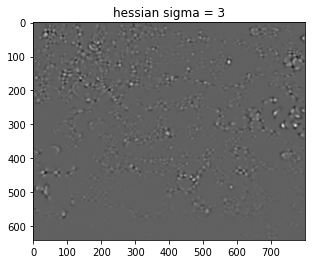

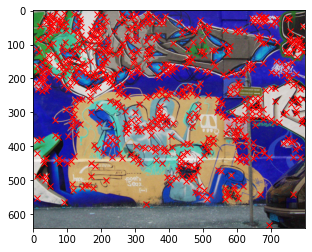

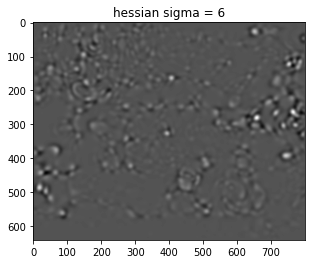

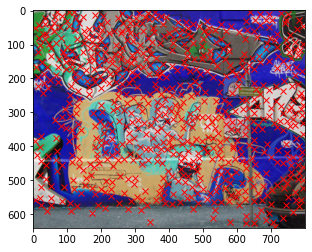

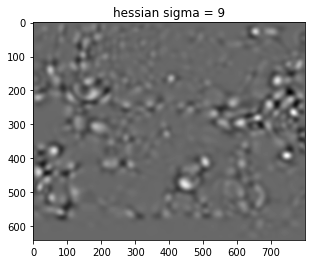

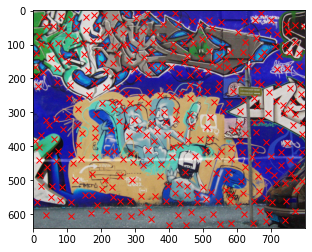

In [5]:
from itertools import product
from scipy import ndimage
from my_utils import get_image_2nd_derivatives, show_images


def get_hessians(src, sigma, plot_hessian=True):
    Ixx, Iyy, Ixy = get_image_2nd_derivatives(src, sigma)
    determinants = (sigma ** 4) * (Ixx * Iyy - Ixy * Ixy)
    if plot_hessian: show_images([determinants], [f'hessian sigma = {sigma}'])
    return determinants


def non_maximum_supression(src):
    src = np.copy(src)
    neighborhood = np.array([[1, 1, 1],
                             [1, 0, 1],
                             [1, 1, 1]])
    neighborhood_max = ndimage.generic_filter(src, lambda x: max(x), footprint=neighborhood, mode='constant', cval=0)
    # return max value of neighborhood for each pixel
    coordinates = product(range(src.shape[0]), range(src.shape[1]))
    for coor, nei_max in zip(coordinates, neighborhood_max.reshape(-1)):
        if src[coor] <= nei_max: src[coor] = 0
    return src


def hessian_points(src, sigma, t):
    src_gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    src_gray = src_gray.astype(float)  #
    hessians = get_hessians(src_gray, sigma)
    hessians[hessians <= t] = 0  # threshold determinant
    supr_det = non_maximum_supression(hessians)
    return [(j, i) for i, j in product(range(supr_det.shape[0]), range(supr_det.shape[1])) if
            supr_det[i, j] != 0]  # get coordinates which values is not zero


def show_points(I, points):
    plt.imshow(I, cmap='gray')
    plt.plot([j for j, _ in points], [i for _, i in points], 'x', color='red')
    plt.show()


I = cv2.imread('data/graf/graf1.jpg')
points_for_diferent_sigma = (hessian_points(I, sigma, 10000) for sigma in [3, 6, 9])
for points in points_for_diferent_sigma:
    show_points(I, points)


**Question**: What kind of structures in the image are detected by the algorithm?
How does the parameter σ affect the result?

Answer: corners, higher sigma takes biger corners

B) Harris detector

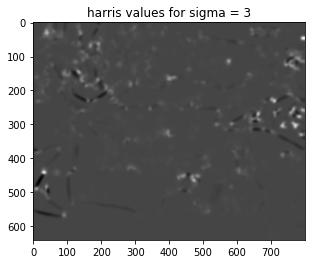

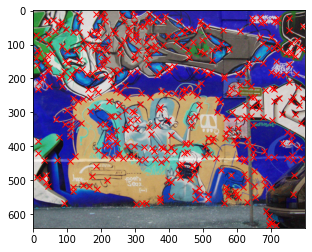

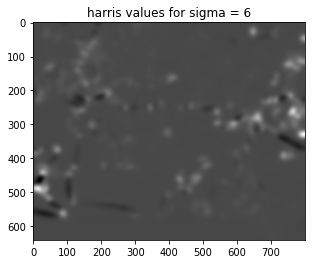

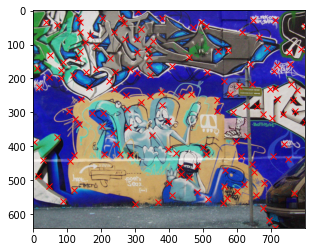

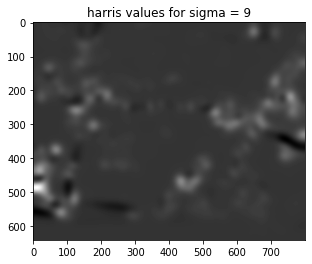

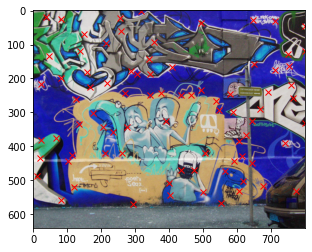

In [6]:
from my_utils import get_image_derivatives, convert_to_2D, gauss, convolve


def get_harris_values(src, sigma, plot_hessian=True):
    Ix, Iy = get_image_derivatives(src, sigma)
    Gx = convert_to_2D(gauss(1.6 * sigma))
    G = convolve(Gx, Gx.T)

    # values of specific matrix indices for whole image
    C11 = convolve(Ix ** 2, G)
    C22 = convolve(Iy ** 2, G)
    C12 = convolve(Ix * Iy, G)

    det = C11 * C22 - C12 ** 2
    trace = C11 + C22
    alpha = 0.06
    values = det - alpha * trace ** 2
    if plot_hessian: show_images([values], [f'harris values for sigma = {sigma}'])
    return values


def harris_points(src, sigma, t):
    src_gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    src_gray = src_gray.astype(float)
    values = get_harris_values(src_gray, sigma)
    values[values <= t] = 0  # threshold values
    supr_det = non_maximum_supression(values)
    return [(j, i) for i, j in product(range(supr_det.shape[0]), range(supr_det.shape[1])) if
            supr_det[i, j] != 0]  # get coordinates which values is not zero


# check corectness on image graf1
I = cv2.imread('data/graf/graf1.jpg')
points_for_diferent_sigma = (harris_points(I, sigma, 10000) for sigma in [3, 6, 9])
for points in points_for_diferent_sigma:
    show_points(I, points)
